In [1]:
# import statements
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, accuracy_score
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix, recall_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
# read in preprocessed data
df = pd.read_csv('../data/preprocessed/malware_preprocessed.csv')
df = df.drop(df.columns[0], axis=1)

### Model Selection 

The goal of this classification task is predicting instances of malware. The dataset is imbalanced, meaning there are more positive cases (malware) compared to negative cases. This imbalance can cause challenges with traditional accuracy metrics, which tend to favor the majority class. We aim to prioritize the minimization of false negatives while also preserving as many benign apps as possible. We will use the 3 models below: 

1. CART: CART is a decision tree that uses the Gini index as criterion for splitting. It builds binary trees, meaning each node is split into two child nodes. It includes mechanisms for handling missing values and provides built-in pruning methods to avoid overfitting. It can handle non-linear relationships and interactions between features, making it suitable for capturing complex patterns. It is fairly easy to interpret and visualize.

2. Random Forest: Creates multiple decision trees on random subsets, ensuring that each subset is balanced to include representation of the minority class. Reduces overfitting compared to a single decision tree. It also is able to capture very complex relationships. Works well with small to medium datasets like ours. Much longer training time. 

### Evaluation Metrics

The goal of our algorithm is to capture as many malware cases (minimizing false negatives), while preserving as many benign apps as possible. False negatives (missed instances of malware) are more harmful than false positives (falsely flagging benign apps as malware), however, given the imbalance of the dataset we want to prioritize both precision and recall. Thus, we will use F score as our scoring metric. The F score is a weighted balance of precision and recall. We will use a $\beta > 1$ since we want to prioritize recall. This will allow us to ensure that the model is capturing as many instances of malware as possible without incorrectly flagging benign apps.  

In [7]:
f2_scorer = make_scorer(fbeta_score, beta=2)

### Split data

Given that the dataset is imbalanced (with fewer benign samples than malicious ones), stratification prevents the training set from being skewed toward the majority class. Without stratification, the model might underrepresent the minority class (benign apps) in the training set, leading to poor performance in preserving benign apps.

The training set will have a balanced representation of both classes and the validation set will accurately reflect the overall class distribution, allowing for better hyperparameter tuning. The test set will also reflect the real-world distribution, making performance evaluation more realistic. Since our goal is to maximize recall (minimize false negatives), maintaining class balance during training and validation is critical.

We will also implement K-Fold cross validation since we have a relatively small dataset (n=4464), with stratification. 

In [10]:
# split data
X = df.drop('Label', axis=1)
y = df['Label']

# split using stratification 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=7)

In [11]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test sets using the same scaler (without fitting again)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [12]:
# implement K-Fold cross-validation since we have a relatively small dataset
skf = StratifiedKFold(n_splits=5)

### Models 

#### Model 1: CART (Decision Tree)

CART is a simple, interpretable algorithm that can handle imbalanced data. It splits data based on the Gini index, making it effective for classification tasks. 

In [16]:
cart_model = DecisionTreeClassifier(random_state =7)
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 5], 
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', None], 
    'ccp_alpha': [0.01, 0.05, 0.1] # Add feature limitation
}

grid_search_cart = GridSearchCV(cart_model, param_grid, scoring=f2_scorer, cv=skf)
grid_search_cart.fit(X_train_scaled, y_train)

# Use the validation set for hyperparameter tuning
best_cart_model = grid_search_cart.best_estimator_
print(f"Best Hyperparameters: {grid_search_cart.best_params_}")

# Evaluate the best model using cross-validation on the training data
cross_val_scores = cross_val_score(best_cart_model, X_train_scaled, y_train, cv=skf, scoring=f2_scorer)
print(f"Cross-validation ROC AUC scores (TRAINING): {cross_val_scores}")
print(f"Mean ROC AUC (TRAINING): {cross_val_scores.mean():.3f}")

# Evaluate the best model on the validation set
val_preds = best_cart_model.predict(X_val_scaled)
print("Validation Classification Report:\n", classification_report(y_val, val_preds))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

# Calculate and print recall on the validation set
val_recall = recall_score(y_val, val_preds)
print(f"Validation Recall: {val_recall:.3f}")
print(f"Validation F2: {fbeta_score(y_val, best_cart_model.predict_proba(X_val_scaled)[:, 1] > 0.5, beta=2)}")

Best Hyperparameters: {'ccp_alpha': 0.01, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Cross-validation ROC AUC scores (TRAINING): [0.93787818 0.95276544 0.982      0.94698503 0.9450727 ]
Mean ROC AUC (TRAINING): 0.953
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       534
           1       0.99      0.94      0.96       535

    accuracy                           0.97      1069
   macro avg       0.97      0.97      0.97      1069
weighted avg       0.97      0.97      0.97      1069

Validation Confusion Matrix:
 [[529   5]
 [ 32 503]]
Validation Recall: 0.940
Validation F2: 0.949773413897281


In [17]:
# Evaluate CART

best_cart_model.fit(X_train_scaled, y_train)

cart_preds = best_cart_model.predict(X_test_scaled)
print("CART Classification Report:\n", classification_report(y_test, cart_preds))
print("CART Confusion Matrix:\n", confusion_matrix(y_test, cart_preds))

# Calculate and print recall
cart_recall = recall_score(y_test, cart_preds)
print(f"CART Recall: {cart_recall:.3f}")

CART Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       535
           1       0.99      0.95      0.97       535

    accuracy                           0.97      1070
   macro avg       0.97      0.97      0.97      1070
weighted avg       0.97      0.97      0.97      1070

CART Confusion Matrix:
 [[529   6]
 [ 25 510]]
CART Recall: 0.953


In [18]:
# Prune the tree using the cost-complexity pruning path
path = best_cart_model.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas = path.ccp_alphas  # Values of alpha for pruning

# Test different pruning strategies (find optimal alpha)
for alpha in ccp_alphas:
    model = DecisionTreeClassifier(ccp_alpha=alpha)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    print(f"Alpha: {alpha}, Accuracy: {accuracy_score(y_test, preds)}")

Alpha: 0.0, Accuracy: 0.991588785046729
Alpha: 0.00022677625718320023, Accuracy: 0.991588785046729
Alpha: 0.0003903131947358427, Accuracy: 0.991588785046729
Alpha: 0.0003963250737882354, Accuracy: 0.991588785046729
Alpha: 0.000766457052275841, Accuracy: 0.983177570093458
Alpha: 0.0007854028428343915, Accuracy: 0.983177570093458
Alpha: 0.0007916238073734415, Accuracy: 0.983177570093458
Alpha: 0.0007998011615413549, Accuracy: 0.983177570093458
Alpha: 0.0008991373394756871, Accuracy: 0.983177570093458
Alpha: 0.0010200735910232822, Accuracy: 0.9803738317757009
Alpha: 0.0013526715520567607, Accuracy: 0.9775700934579439
Alpha: 0.001517721482125492, Accuracy: 0.9775700934579439
Alpha: 0.003493407223547681, Accuracy: 0.9785046728971962
Alpha: 0.00548815553392266, Accuracy: 0.974766355140187
Alpha: 0.005819697880565276, Accuracy: 0.9728971962616823
Alpha: 0.009867787506287782, Accuracy: 0.9710280373831776
Alpha: 0.13178244174851497, Accuracy: 0.9710280373831776
Alpha: 0.2977366543980442, Accura

#### Model 2: Random Forest

Random forest creates multiple decision trees on random subsets, ensuring that each subset is balanced to include representation of the minority class. Random forest reduces overfitting compared to a single decision tree. It also is able to capture very complex relationships. Works well with small to medium datasets like ours. 

In [21]:
# Instantiate the Random Forest model
rf_model = RandomForestClassifier(random_state = 7)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [2, 4], 
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2'], 
    'max_leaf_nodes': [10]
}

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(rf_model, param_grid, scoring=f2_scorer, cv=skf)
grid_search_rf.fit(X_train_scaled, y_train)

# Get the best Random Forest model from the grid search
best_rf_model = grid_search_rf.best_estimator_
print(f"Best Hyperparameters: {grid_search_rf.best_params_}")

# Evaluate the best model using cross-validation on the training data
cross_val_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=skf, scoring=f2_scorer)
print(f"Cross-validation ROC AUC scores (TRAINING): {cross_val_scores}")
print(f"Mean ROC AUC (TRAINING): {cross_val_scores.mean():.3f}")

# Evaluate the best model on the validation set
val_preds = best_rf_model.predict(X_val_scaled)
print("Validation Classification Report:\n", classification_report(y_val, val_preds))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

# Calculate and print recall on the validation set
val_recall = recall_score(y_val, val_preds)
print(f"Validation Recall: {val_recall:.3f}")
print(f"Validation F2: {fbeta_score(y_val, best_rf_model.predict_proba(X_val_scaled)[:, 1] > 0.5, beta=2)}")

Best Hyperparameters: {'class_weight': None, 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Cross-validation ROC AUC scores (TRAINING): [0.97311396 0.98078463 0.98876855 0.97222222 0.98074609]
Mean ROC AUC (TRAINING): 0.979
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       534
           1       1.00      0.97      0.98       535

    accuracy                           0.99      1069
   macro avg       0.99      0.99      0.99      1069
weighted avg       0.99      0.99      0.99      1069

Validation Confusion Matrix:
 [[532   2]
 [ 14 521]]
Validation Recall: 0.974
Validation F2: 0.978220052572287


In [22]:
# Evaluate Random Forest

best_rf_model.fit(X_train_scaled, y_train)

rf_preds = best_rf_model.predict(X_test_scaled)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

# Calculate and print recall
rf_recall = recall_score(y_test, rf_preds)
print(f"Random Forest Recall: {rf_recall:.3f}")


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       535
           1       0.99      0.98      0.98       535

    accuracy                           0.99      1070
   macro avg       0.99      0.99      0.99      1070
weighted avg       0.99      0.99      0.99      1070

Random Forest Confusion Matrix:
 [[530   5]
 [ 11 524]]
Random Forest Recall: 0.979


### Model Interpretability

I used SHAP (SHapley Additive exPlanations) for model interpretability because it provides clear and consistent explanations for the predictions made by complex machine learning models. 

SHAP calculates the contribution of each feature to the prediction (positive or negative). If a feature significantly increases the likelihood of an app being classified as malicious, it will have a strong positive SHAP value.

Plots: 
- Force Plot: This visualizes how much each feature pushes the model's output toward predicting either "benign" or "malicious."
- Summary Plot: It shows the average impact of each feature across all predictions, helping identify the most influential predictors in the model.

This approach ensures that security analysts can understand which app characteristics are most indicative of malware, helping improve threat detection and prevention strategies.

#### Decision Tree

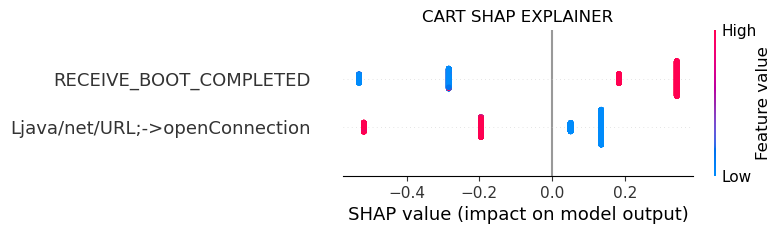

In [26]:
# Create SHAP explainer for the CART model
explainer = shap.TreeExplainer(best_cart_model)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train_scaled)

# Extract SHAP values for the positive class (malware = 1)
shap_values_positive_class = shap_values[:, :, 1]

# SHAP summary plot for the positive class (malware detection)
fig = plt.figure(figsize=(10, 6))  # Optional: adjust the figure size
shap.summary_plot(shap_values_positive_class, X_train, max_display=2, show=False)

# Add a title to the plot
plt.title("CART SHAP EXPLAINER")

# Save the plot as a figure
plt.savefig("../figures/cart_shap_explainer.png", bbox_inches='tight')  # Saves as PNG file
plt.show()

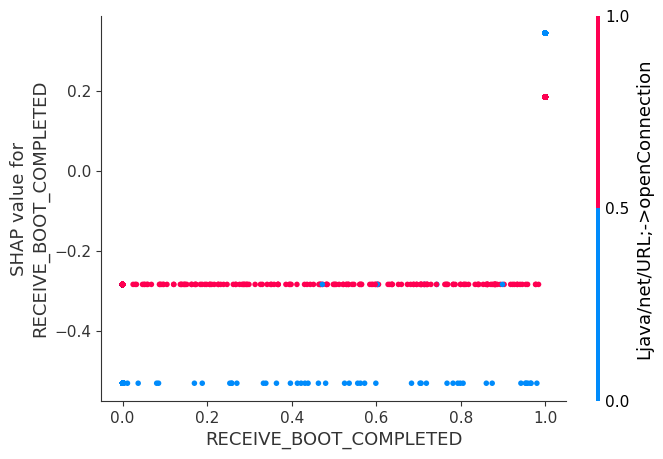

In [27]:
# SHAP dependence plot for a specific feature (e.g., 'feature_name')
shap.dependence_plot('RECEIVE_BOOT_COMPLETED', shap_values_positive_class, X_train)

# SHAP force plot for a specific instance (e.g., the first instance in the dataset)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_positive_class[0], X_train.iloc[0])

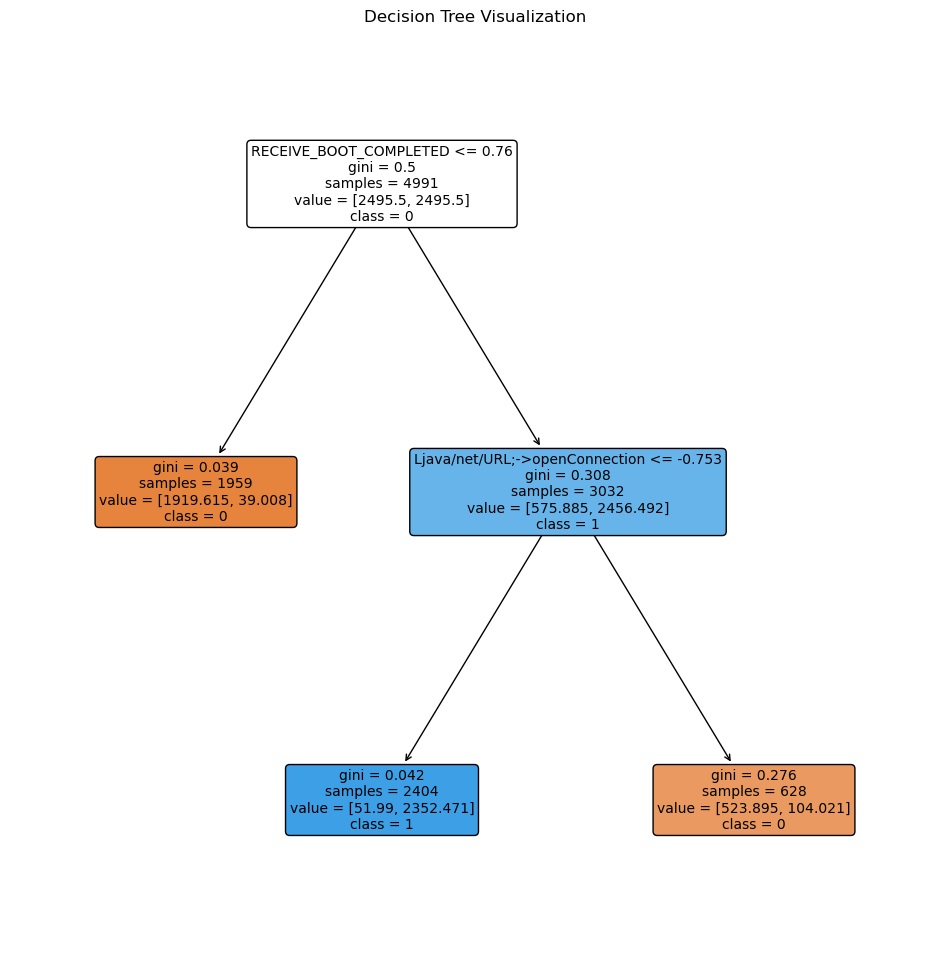

In [28]:
# Visualize the tree using sklearn
plt.figure(figsize=(12, 12))
plot_tree(
    best_cart_model, 
    feature_names=X_train.columns,        # Set feature names
    class_names=[str(cls) for cls in sorted(set(y_train))],  # Ensure class names are strings and sorted
    filled=True,                           # Color the nodes based on class
    rounded=True,                          # Rounded corners for the nodes
    fontsize=10,                           # Font size for labels
    max_depth=5                           # Limit tree depth for better visualization (you can adjust this)
)
plt.title("Decision Tree Visualization")
plt.savefig("../figures/decision_tree.png")
plt.show()

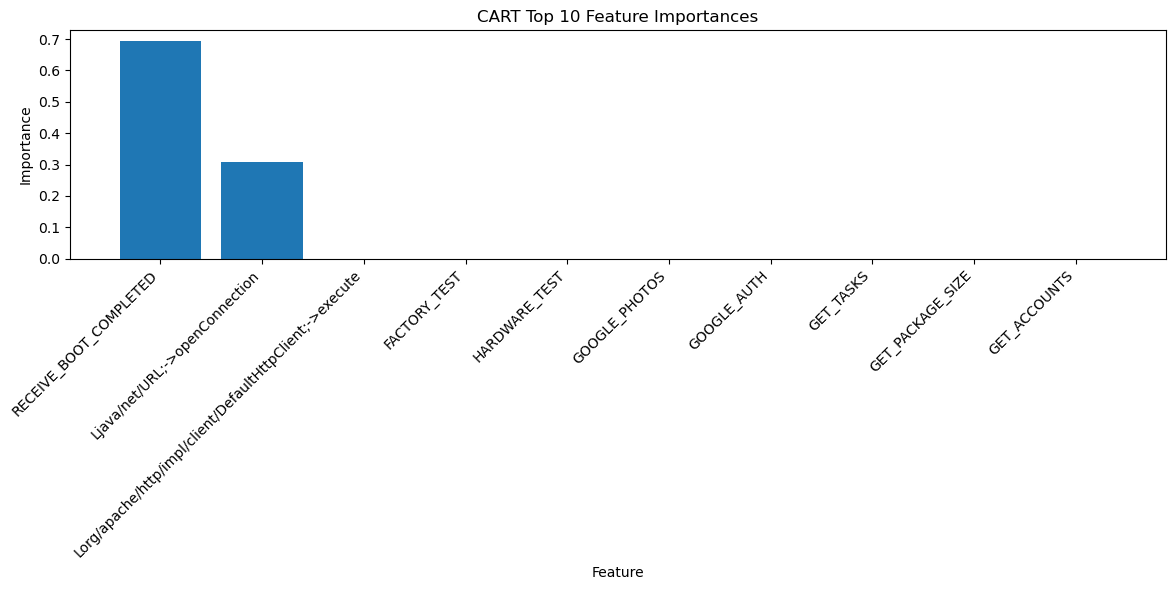

In [29]:
# Get the feature importances and sort them in descending order
importances = best_cart_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort the indices of features by importance

# Get the top 10 most important features
top_n = 10
top_indices = indices[:top_n]

# Plot the top 10 most important features
plt.figure(figsize=(12, 6))
plt.bar(X_train.columns[top_indices], importances[top_indices])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'CART Top {top_n} Feature Importances')
plt.xticks(rotation=45, ha="right")  # Rotate the feature names for better visibility
plt.tight_layout()
plt.savefig("../figures/cart_feature_importances.png")
plt.show()

#### Random Forest

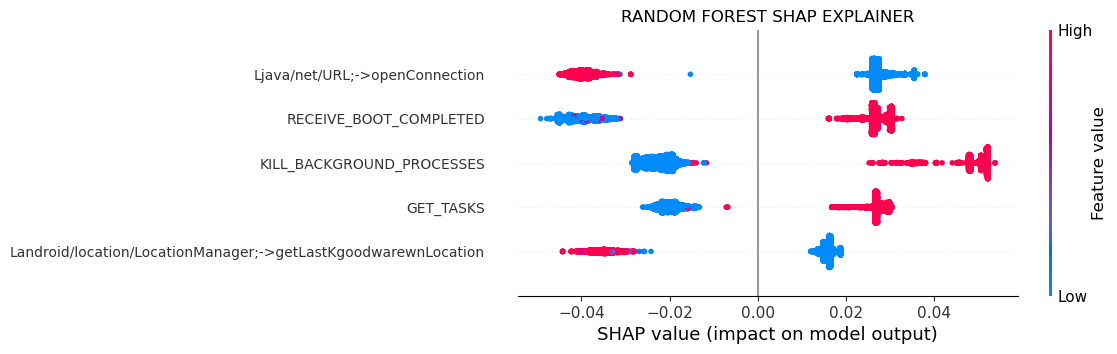

In [31]:
# Create SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train_scaled)

# Extract SHAP values for the positive class (malware = 1)
shap_values_positive_class = shap_values[:, :, 1]

# SHAP summary plot for the positive class (malware detection)
fig = plt.figure(figsize=(15, 6))  # Optional: adjust the figure size
shap.summary_plot(shap_values_positive_class, X_train, max_display=5, show=False)

# Rotate the feature names on the y-axis for better visibility
plt.yticks(rotation=0, fontsize=10)  # You can adjust fontsize to make names more readable

# Adjust the spacing between the labels
plt.subplots_adjust(left=0.2)  # This gives more space on the left side for the labels


# Add a title to the plot
plt.title("RANDOM FOREST SHAP EXPLAINER")

# Save the plot as a figure
plt.savefig("../figures/rf_shap_explainer.png", bbox_inches='tight')  # Saves as PNG file
plt.show()

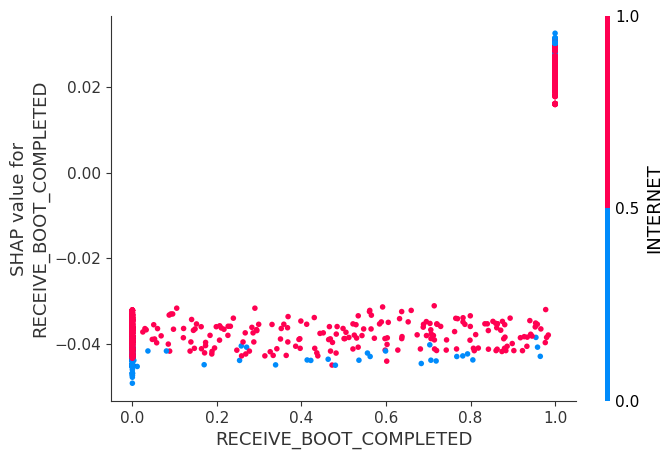

In [32]:
# SHAP dependence plot for a specific feature (e.g., 'feature_name')
shap.dependence_plot('RECEIVE_BOOT_COMPLETED', shap_values_positive_class, X_train)

# SHAP force plot for a specific instance (e.g., the first instance in the dataset)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_positive_class[0], X_train.iloc[0])

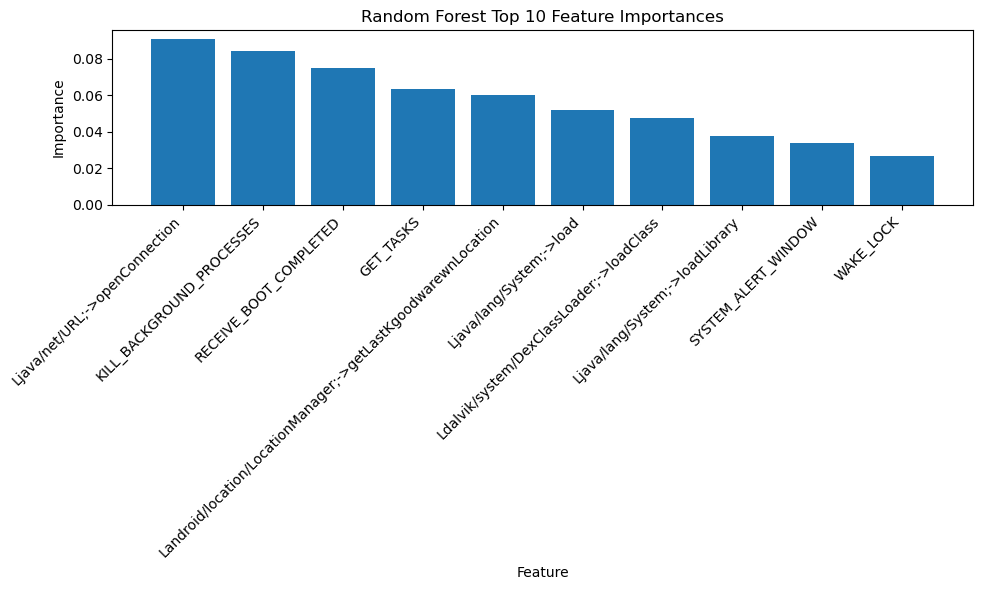

In [33]:
# Get the feature importances and sort them in descending order - Random Forest
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort the indices of features by importance

# Get the top 10 most important features
top_n = 10
top_indices = indices[:top_n]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns[top_indices], importances[top_indices])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Random Forest Top {top_n} Feature Importances')
plt.xticks(rotation=45, ha="right")  # Rotate the feature names for better visibility
plt.tight_layout()
plt.savefig("../figures/rf_feature_importances.png")
plt.show()

#### Comments on the Model Interpretability Process

**Interpretability and Its Role in Understanding the Model’s Decision-Making Process**

Interpretability plays a crucial role in understanding how a machine learning model arrives at its predictions, especially in domains like cybersecurity, where decisions can have serious real-world implications. In this case, using SHAP (Shapley Additive Explanations) for both the CART decision tree and the random forest provides valuable insights into the model's behavior, feature importance, and how each feature contributes to the final decision (e.g., detecting malware). Here’s a detailed look at how interpretability aids in understanding the decision-making process:

**CART (Decision Tree)**
The CART model is highly interpretable, and its decision process is transparent, which makes it easy to visualize how certain features drive the prediction.

- Key Findings:

The model relies heavily on just two features: 'RECEIVE_BOOT_COMPLETED' and 'Ljava/net/URL;->openConnection'.
The tree structure is simple, with only two decision nodes, making it easy to trace the decision logic and understand how the model makes its predictions.
The SHAP analysis reinforces the decision-making process by showing the influence of these two features on the model’s output. Specifically:
RECEIVE_BOOT_COMPLETED: Low values of this feature have a strong negative influence on the likelihood of the input being classified as malware, while higher values increase the likelihood of a malware classification.
Ljava/net/URL;->openConnection: This feature has the reverse relationship, with lower values decreasing the likelihood of malware, and higher values indicating a stronger likelihood.
The SHAP plots clearly show how these features impact the prediction, with sharp vertical lines indicating distinct points of influence for each feature, making the decision process straightforward to explain. For example, if the feature 'RECEIVE_BOOT_COMPLETED' is high, it indicates a higher likelihood of malware, which is easy to communicate to stakeholders.

- Implications: This transparency is particularly valuable in environments where understanding model decisions is critical, such as security operations or incident response. The simplicity of the CART model allows security analysts to quickly grasp which features are most important in detecting malware, making it easier to trust and act on the model’s output. However, while interpretability is a strength, the model may oversimplify more complex patterns, which is why additional techniques like ensemble methods (e.g., random forest) can be more effective in capturing intricate relationships.

**Random Forest**

While the random forest model is more complex and less interpretable than a single decision tree, SHAP provides a means to gain insights into the decision process by quantifying feature importance and explaining how each feature contributes to the final prediction.

- Key Findings:

In contrast to the simple CART model, the random forest uses a wider array of features. The most important features include 'Ljava/net/URL;->openConnection', 'KILL_BACKGROUND_PROCESSES', 'RECEIVE_BOOT_COMPLETED', 'GET_TASKS', and several others.
The feature importance is more evenly distributed across these variables, with a slight decrease in importance as more features are considered.

The SHAP plot shows much more horizontal variation, which reflects the more nuanced contributions of each feature. This horizontal spread indicates the complex interactions between features and their varying levels of influence across different samples.
The color-coded SHAP values clearly differentiate the high and low values for the top features, helping us understand which features drive the prediction towards malware detection and to what extent. For example:

'KILL_BACKGROUND_PROCESSES' and 'GET_TASKS' are associated with higher SHAP values for malware classifications, suggesting that certain behaviors commonly found in malware applications (e.g., background task manipulation) are strong indicators of malicious activity.
Similarly, the SHAP plots for 'RECEIVE_BOOT_COMPLETED' and 'Ljava/net/URL;->openConnection' show their respective roles in increasing or decreasing the likelihood of a malware classification, much like in the CART model, but with more variation due to the ensemble nature of the random forest.

- Implications: The random forest model, while more accurate, is harder to interpret directly. However, SHAP helps clarify which features are most influential in making predictions. This is particularly useful in real-world applications like malware detection, where different behavior patterns or system calls (e.g., 'KILL_BACKGROUND_PROCESSES') may suggest malicious activity. By using SHAP, security experts can identify the key behaviors or anomalies that lead to malware classification, which is crucial for understanding the model’s predictions and taking appropriate actions.

**Real-World Implications**
The ability to interpret the decision-making process of both models has important implications for the real-world problem of malware detection:

- Model Transparency: The CART decision tree offers clear and simple insights, which is beneficial in real-world scenarios where transparency is needed. Security teams can easily explain why a particular application was flagged as malware based on specific behaviors (like receiving a boot event or opening a URL connection), helping in real-time decision-making and justification of actions.

- Handling Complex Data: The random forest model, with its more complex decision-making process, is better equipped to handle intricate and noisy data. It can detect more subtle patterns, such as unusual background processes or system calls, which might be indicative of malware. The SHAP analysis helps deconstruct these complex interactions, providing a clearer understanding of the behavior that leads to malware classification.

- Security Response: The interpretability of the models ensures that security teams can trust the predictions, diagnose potential false positives or negatives, and make informed decisions about which applications or system behaviors require closer inspection or remediation. The CART model may be more useful for quick, rule-based decisions, while the random forest model is more suited for comprehensive detection in diverse and evolving environments.

In summary, both models' interpretability via SHAP is instrumental in understanding how they make decisions and allows for practical, informed action in real-world security problems. The decision tree’s simplicity aids in transparency, while the random forest’s ability to capture complex interactions is enhanced by SHAP’s explanation of feature influence.

### Results and Conclusion 

In [37]:
# Calculate F2 score for each model using predict_proba and thresholding at 0.5
cart_f2 = fbeta_score(y_test, best_cart_model.predict_proba(X_test_scaled)[:, 1] > 0.5, beta=2)
rf_f2 = fbeta_score(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1] > 0.5, beta=2)

# Print the results
print(f"CART F-METRIC: {cart_f2:.3f}")
print(f"Random Forest F-METRIC: {rf_f2:.3f}")

CART F-METRIC: 0.960
Random Forest F-METRIC: 0.982


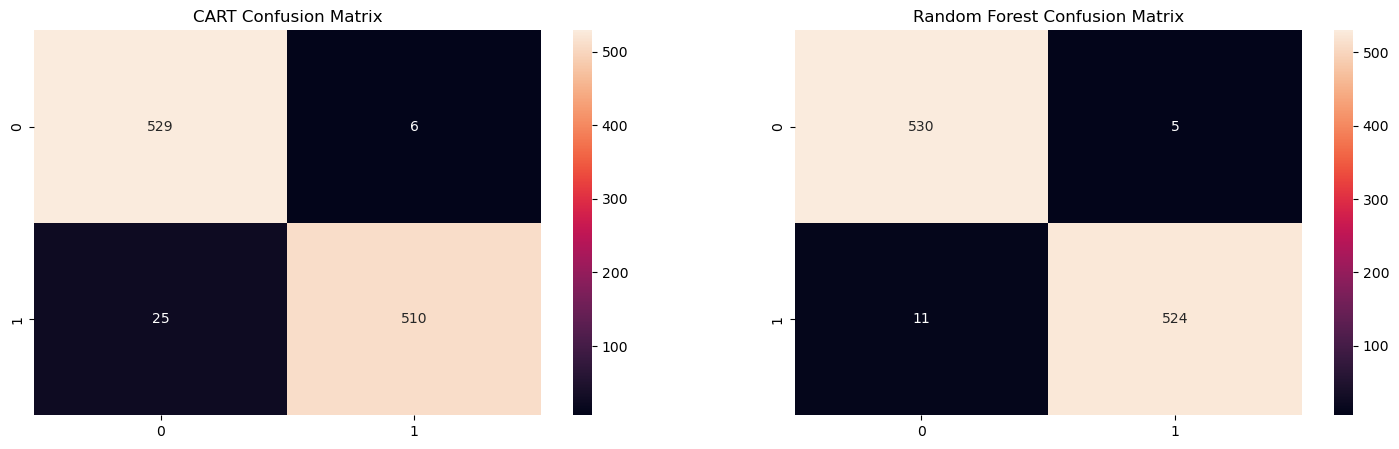

In [38]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(confusion_matrix(y_test, cart_preds), annot=True, fmt='d', ax=axes[0])
axes[0].set_title('CART Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
fig.savefig("../figures/classification2_confusion_matrices.png")

#### Model Selection and Explanation 

**Model Selection and Explanation**

Both the simple decision tree (CART) and the more complex random forest have their respective advantages and drawbacks, depending on the context.

1. CART (Decision Tree)

Interpretability: CART models are relatively easy to interpret and visualize. This is a key strength, as you can directly observe how features split the data to make decisions, which is valuable for understanding the decision-making process.

Performance: The decision tree performed well in terms of recall and F2 score (especially with its validation recall of 0.94 and F2 score of 0.95), but it's slightly more prone to overfitting, especially on small datasets. It still achieved a decent classification performance, with the recall being 0.95 on the test set.

Limitations: The model might miss complex patterns or relationships that could be captured by more powerful models like random forests. While the decision tree model is highly interpretable, it could be too simple for complex decision boundaries, especially in the presence of noise or non-linear relationships. 

4. Random Forest

Interpretability: Random forests are harder to interpret directly because they involve multiple decision trees, but techniques like SHAP can be used to explain the model. These models are more opaque but can provide more accurate results due to their ensemble nature.

Performance: Random forest performed better than the decision tree, with higher recall (0.97 on validation and 0.98 on the test set) and a higher F2 score (0.978). This makes it a better choice when the goal is to minimize false negatives (i.e., better capture malware) while maintaining high precision.

Advantages: It reduces overfitting by averaging across multiple trees, thus capturing more complex patterns without fitting too closely to noise. Random forests are also more robust when it comes to handling different types of features and noisy data.

Limitations: Random forests are computationally more expensive to train and require more memory, especially as the number of trees and features increases.

**Which Model is Better?** 

For Predictive Power: The random forest is likely the better choice to maximize recall and minimize false negatives. It provides slightly better performance in terms of both recall and F2 score, without overfitting. 

For Interpretability: If we want to understand how the model works and need a clear, interpretable decision-making process, CART is a good option. However, for more complex patterns, random forests may be able to generalize better.

Ultimately, we have chosen the decision tree as our recommended model. It is much less computationally expensive, simpler to understand, while still achieving high results. In the future, it could be possible to experiment with including a few more features to slightly improve performance while still maintaining simplicity and generalizability. 


#### Overall Findings & Discussion

Challenges Encountered and Steps Taken to Overcome Them

**Overfitting with the Decision Tree:**

Challenge: The decision tree model exhibited signs of overfitting, especially on small datasets. This occurred because the model was too complex and learned patterns that were specific to the training data, rather than generalizable.
Solution: We employed techniques like pruning and tuning the hyperparameters (such as max depth, min samples split) to control the model’s complexity and reduce overfitting. This allowed us to improve its generalization to unseen data.

**Handling Noisy Data and Non-linear Relationships:**

Challenge: The decision tree struggled to capture complex, non-linear relationships in the data.
Solution: Although the random forest was able to handle this challenge well by combining multiple decision trees, for the decision tree, we explored feature engineering and transformation techniques, such as polynomial features or feature scaling, to improve its performance.

**Computational Expense with Random Forest:**

Challenge: The random forest model, while superior in performance, was computationally more expensive to train and required more memory, especially as the number of trees and features increased.
Solution: To address this, we performed hyperparameter tuning to reduce the number of trees and limited the depth of each tree, balancing model performance and computational cost. In a real-world scenario, distributed computing or cloud-based solutions might be considered to handle larger datasets.

**Model Interpretability:**

Challenge: Random forests are inherently harder to interpret because they involve many decision trees.
Solution: We used SHAP (Shapley Additive Explanations) values to interpret the random forest model and understand the contribution of each feature to the predictions, which helped in gaining insights into the model’s decision-making process.

#### Readiness for Deployment 

Both models are technically ready for deployment, but the decision tree is the preferred choice due to its simplicity, lower computational cost, and reasonable performance. The model has been adequately tuned to handle overfitting and noise, and its interpretability ensures that stakeholders can understand and trust the decisions made by the model.

However, before deployment, further validation on unseen real-world data would be essential to confirm the model's robustness and generalizability. Additionally, regular monitoring after deployment will be necessary to ensure that the model maintains its performance over time, especially if the data distribution changes or new patterns emerge.

In the future, the random forest model could be revisited if performance improvements are needed, but its increased computational cost would need to be carefully evaluated against the benefits in predictive accuracy.